In [5]:
import numpy as np
import matplotlib.pyplot as plt
from math import gamma
from scipy.special import kv

import sys
sys.path.append('../../funcs')
from spectral1d import QuantumReflection

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT

from qiskit.circuit.library import PiecewisePolynomialPauliRotationsGate
from numpy.polynomial import polynomial as poly

In [6]:
def forcing(x, x_f, tau, l):
    """Forcing function"""
    forcing_function = np.zeros(len(x))

    fac = 1.
    for i in range(len(x)):
        if x[i] == x_f:
            forcing_function[i] = 1/tau
        else:
            forcing_function[i] = 0

    return fac*forcing_function

def break_points_pwc(n_pts, eps=1e-6): 
    """Break points for piecewise Chebychev interpolation"""
    """One end of the spectrum are refined as a geometric series"""
    pt = n_pts // 2
    break_pts_1 = []

    # break points for the first half of the spectrum
    while pt > 1:
        pt = pt // 2
        break_pts_1.append(pt-eps)

    # break points for the second half of the spectrum
    break_pts_1 = break_pts_1[::-1]
    break_pts_1.append((n_pts/2)-eps)
    break_pts_1.append(n_pts-eps)

    # combine the two lists and return
    return (break_pts_1)


In [7]:

def polynomials(func, degree, breakpoints):
    num_intervals = len(breakpoints)

    polynomials = []
    
    for i in range(num_intervals-1):
        x = np.linspace(breakpoints[i], breakpoints[i + 1], num=degree+1)
        
        # Vandermonde matrix
        van_mat = poly.polyvander(x, degree)
         
        # condition Vandermonde matrix to avoid ill-conditioning
        scale = np.abs(van_mat).sum(axis=0)
        van_mat /= scale

        poly_coeffs, resids, rank, s = np.linalg.lstsq(van_mat, func(x), rcond=None)
        poly_coeffs = (poly_coeffs.T / scale).T  

        polynomials.append(poly_coeffs.tolist())

    return polynomials

/var/folders/tn/bpv7203512s5w_qmpd5848z80000gn/T/ipykernel_11413/875176860.py:53: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(num_qubits=n_state_qubits_ext,inverse=False).to_gate()


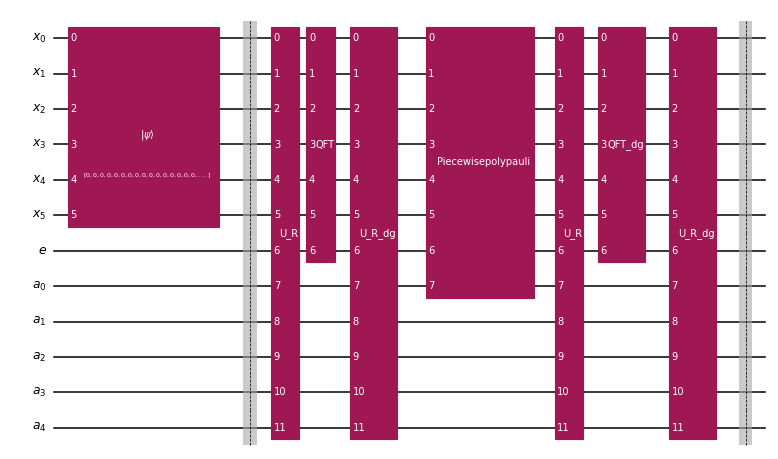

In [8]:
# number of qubits for discretisation
n_state_qubits     = 6                      # excluding the extended domain
n_state_qubits_ext = n_state_qubits + 1     # including the extended domain

n_pts     = 2**n_state_qubits
n_pts_ext = 2**n_state_qubits_ext

# discretise the domain interval [0,1]
l     = 1.      # domain
l_ext = 2*l     # extended domain
h     = l/n_pts 
x     = np.linspace(0, l-h, n_pts)

# spde problem definition
nu    = 5/2
dim   = 1
sigma = 1
ell   = 0.05
beta  = (nu/2) + (dim /4)  # beta is (1/2, 1, and 3/2) for nu = (1/2, 3/2, and 5/2)
kappa = np.sqrt(2 * nu) / ell
tau   = np.sqrt(gamma(nu) / (sigma**2 * gamma(nu + dim/2) * (4. * np.pi)**(dim/2) * (kappa ** (2*nu))))

# forcing vector
x_f    = 1/2  # location of the point load
f_i    = forcing(x, x_f, tau, 1)
f_i[0] = 0.   # make sure zero at the first element
norm_f = np.linalg.norm(f_i)
f      = f_i/norm_f

method_p = "ripple-carry"  
if method_p == "mcx":
    n_ancillas = 1
else:
    n_ancillas = n_state_qubits -1

# initialise quantum circuit with n_state_qubits and n_state_qubits+1 ancillas
qcs = QuantumRegister(n_state_qubits, 'x')  # spatial discretisation qubits
qce = QuantumRegister(1, 'e')               # extension qubit
qca = QuantumRegister(n_ancillas, 'a')  # ancillary qubits
qc  = QuantumCircuit(qcs, qce, qca)

# initialise state using in-built Qiskit state prep function
qc.initialize(f, list(range(n_state_qubits)))
qc.barrier()

# add reflection unitary U_R to the circuit
method_u_f = "ripple-carry"
qr = QuantumReflection(n_state_qubits, 1, method_u_f=method_u_f)
qr_gate = qr.build()
qc.append(qr_gate, list(range(qr.n_dst)))

# apply QFT
qft = QFT(num_qubits=n_state_qubits_ext,inverse=False).to_gate()
qc.append(qft, list(range(n_state_qubits_ext)))

# add inverse of U_R to the circuit
qref_inv = qr.inverse()
qr_inv_gate = qref_inv.to_gate(label="U_R_dg")
qc.append(qr_inv_gate, list(range(qr.n_dst)))  

# piecewise polynomial approximation
degree = 3      # degree of the Chebyshev approximation

# function to approximate
@np.vectorize(otypes=[float])
def twoTheta(k):
    # factor of 2 is needed because Ry(2θ) applies the rotation by θ
    if k == 0:
        return 0
    return 2*np.arccos(1 / ((kappa**2)+(np.pi*k/l)**2)**(2*beta))

# set breakpoints for piecewise polynomial approximation
breakpoints = [1, degree+1, 2*degree+1, 3*degree+1, 4*degree+1, 8*degree+1,  16*degree+1, n_pts]  

poly_coeffs = polynomials(twoTheta, degree, breakpoints)

pw_approximation = PiecewisePolynomialPauliRotationsGate(n_state_qubits, breakpoints, poly_coeffs)
qc.append(pw_approximation, list(range(n_state_qubits+2)))

# apply inverse spectral transformation
qc.append(qr_gate, list(range(qr.n_dst)))
qc.append(qft.inverse(), list(range(n_state_qubits_ext))) 
qc.append(qr_inv_gate, list(range(qr.n_dst))) 

qc.barrier()

# visualize circuit
qc.draw("mpl", scale=0.55)

In [9]:
state = Statevector.from_label('0' * qc.num_qubits)
state = state.evolve(qc)

# extract the result from the state 
out = np.array(state.data[0:2*n_pts_ext])

result = np.real((1/tau)*n_pts*norm_f*out)
# np.savetxt('matern-cov-1d-5p2.txt', result[0:n_pts])

# result_vec = 1/np.max(result[0:n_pts])*result[0:n_pts]
result_vec = result[0:n_pts]

def solutionAnalytic(x):
    """Analytic solution"""
    # Matern covariance function
    if(np.linalg.norm(x - x_f) == 0):
         cs = sigma**2
    else:
        cs = (sigma**2)/((2**(nu-1)) * gamma(nu)) * (((np.sqrt(2*nu)/ell) * np.linalg.norm(x - x_f))**(nu)) * kv(nu, (np.sqrt(2*nu)/ell) * np.linalg.norm(x - x_f))
    return cs

anlyt = np.zeros(n_pts)
for j in range(n_pts):
    anlyt[j] = solutionAnalytic(x[j])

# L2 norm of the error
error = np.linalg.norm(result_vec - anlyt)
print('L2 norm of the error: ', error / n_pts)

L2 norm of the error:  3.697813229451486e-05


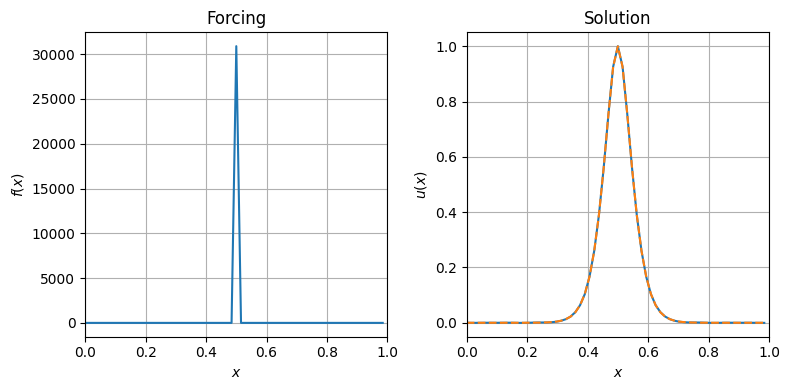

In [10]:
# plot the forcing and solution
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1) 
plt.title('Forcing') 
plt.plot(x, f_i)
plt.xlim(0, l)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.grid()

plt.subplot(1, 2, 2)  
plt.title('Solution')
plt.plot(x, (result_vec))
plt.plot(x, anlyt, '--')
plt.xlim(0, l)
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.grid()

plt.tight_layout()
plt.show()

In [11]:
from qiskit.compiler import transpile
transp = transpile(qc, basis_gates=['u3','cx'],optimization_level=3)
transp.count_ops()

OrderedDict([('u3', 44648), ('cx', 36128), ('reset', 6), ('barrier', 2)])

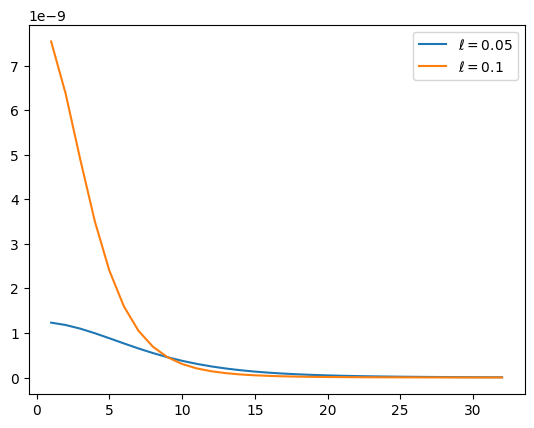

In [12]:
t=np.linspace(1,32,32)

l1 = 0.05
l2 = 0.1

kappa1 = np.sqrt(2 * nu) / l1
kappa2 = np.sqrt(2 * nu) / l2

def f1(k):
    return 1 / ((kappa1**2)+(np.pi*k)**2)**(2*beta)

def f2(k):
    return 1 / ((kappa2**2)+(np.pi*k)**2)**(2*beta)

plt.plot(t, 10*f1(t), label=r'$\ell = 0.05$')
plt.plot(t, f2(t), label=r'$\ell = 0.1$')
plt.legend()
plt.show()